# RNA pulse 5 substance independent

The model RNA-pulse describes the damage dynamic as a expression pulse. It uses a sigmoid function to model the threshold dependent activation of *Nrf2* expression and a concentration dependent exponential decay of RNA molecules. Coupled with active metabolization of the internal concentration of the chemical this leads to a pulse like behavior. In addition *Nrf2* serves as a proxy for toxicodynamic damage

## 💥 Attention

1. When calculating treatment effects it should be made sure that effects are calculated differentially to the initial value of the RNA expression
2. When $R_0 \neq 1$, the RNA expression has to be divided by the baseline to obtain fold-change values, after the ODE has been solved.


## Imports

First, I apply some modifications to the jupyter notebook for a cleaner experience.
Warnigns are ignored, the root directory is changed to the base of the repository.
Then relevant packages are imported for the case study and its evaluation

In [2]:
import os
import json
import warnings
from functools import partial

import numpy as np
import arviz as az
import matplotlib as mpl
from matplotlib import pyplot as plt

from pymob import Config
from tktd_rna_pulse.sim import SingleSubstanceSim3

warnings.filterwarnings("ignore")

In [3]:
config = Config(config="../scenarios/rna_pulse_5_substance_independent_rna_protein_module/settings.cfg")
# change the package directory, because working in a jupyter notebook sets the root to the folder of the working directory
# the package gives the base directory of the case-study
config.case_study.package = "../.."
sim = SingleSubstanceSim3(config)
sim.setup()

MinMaxScaler(variable=cint, min=0.0, max=6364.836264471382)
MinMaxScaler(variable=nrf2, min=0.0, max=3.806557074337876)
MinMaxScaler(variable=survival, min=0.0, max=18.0)
Results directory exists at '/home/flo-schu/projects/pymob/case_studies/tktd_rna_pulse/results/rna_pulse_5_substance_independent_rna_protein_module'.
Scenario directory exists at '/home/flo-schu/projects/pymob/case_studies/tktd_rna_pulse/scenarios/rna_pulse_5_substance_independent_rna_protein_module'.


## Parameter inference

Parameter inference estimates the value of the parameters given the data 
presented to the model.

Here we calculate a maximum a posteriori (MAP) estimate which is the mode
of the posterior distribution.

In [4]:
# set up the inferer properly
sim.set_inferer("numpyro")

Jax 64 bit mode: False
Absolute tolerance: 1e-06



First of all prior predictions are generated. These are helpful to diagnose
the model and also to compare posterior parameter estimates with the prior
distributions. If there is a large bias, this information can help to achieve
a better model fit. We can speed up the prior predictive sampling, if we let
the model only sample the prior distributions `only_prior=True`

In [ ]:
# prior predictions
seed = 1
prior_predictions = sim.inferer.prior_predictions(n=100, seed=seed)

In the next step, we take the full model, including deterministic ODE solution
and error model and run our SVI estimator on it, with the parameters that have
been setup before.

In [ ]:
# set the inference model
sim.config.inference_numpyro.kernel = "svi"
sim.config.inference_numpyro.svi_iterations = "5000"
sim.config.inference_numpyro.svi_learning_rate = "0.01"
sim.inferer.run()

In [14]:

# show (and explore idata)
print(sim.inferer.idata)

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> observed_data
	> unconstrained_posterior
	> posterior_model_fits
	> posterior_residuals
	> posterior
	> posterior_predictive
	> log_likelihood
	> observed_data
	> posterior_model_fits
	> posterior_residuals


In [7]:
sim.inferer.store_results(f"{sim.output_path}/numpyro_svi_posterior.nc")

## Posterior predictions

In order to evaluate the goodness of fit for the posteriors, we are looking
at the posterior predictions.

In order to obtain smoother trajectories, the time resolution is increased,
and posterior predictions are calculated.

In [13]:
sim.coordinates["time"] = np.linspace(24, 120, 100)
sim.dispatch_constructor()
seed = int(np.random.random_integers(0, 100, 1))

res = sim.inferer.posterior_predictions(n=1, seed=seed).mean(("draw", "chain"))
print(res)

Posterior predictions: 100%|██████████| 1/1 [00:02<00:00,  2.32s/it]

<xarray.Dataset>
Dimensions:          (id: 202, time: 100)
Coordinates:
  * id               (id) object '101_0' '101_1' '106_0' ... '66_4' '66_5' '6_0'
  * time             (time) float64 24.0 24.97 25.94 26.91 ... 118.1 119.0 120.0
    hpf              (id) float64 24.0 24.0 24.0 24.0 ... 24.0 24.0 24.0 24.0
    nzfe             (id) float64 nan nan nan nan nan ... 9.0 9.0 9.0 9.0 20.0
    treatment_id     (id) int64 101 101 106 106 112 112 118 ... 66 66 66 66 66 6
    experiment_id    (id) int64 36 36 36 36 36 36 36 36 ... 27 27 27 27 27 27 1
    substance        (id) <U10 'diuron' 'diuron' ... 'naproxen' 'naproxen'
    substance_index  (id) int64 0 0 0 0 0 0 0 0 0 0 0 ... 2 2 2 2 2 2 2 2 2 2 2
Data variables:
    cext             (id, time) float32 2.34 2.34 2.34 ... 349.5 349.5 349.5
    cint             (id, time) float32 0.0 26.59 53.15 ... 2.914e+03 2.887e+03
    nrf2             (id, time) float32 1.0 1.014 1.028 ... 2.61 2.589 2.568
    P                (id, time) float32 0.0

Next, we plot the predictions against selected experiments. Note that the observations,
may be slightly diverging from the MAP predictions, because
a) the model is not completely correct
b) other data *pull* the posterior estimate away from the displayed data.

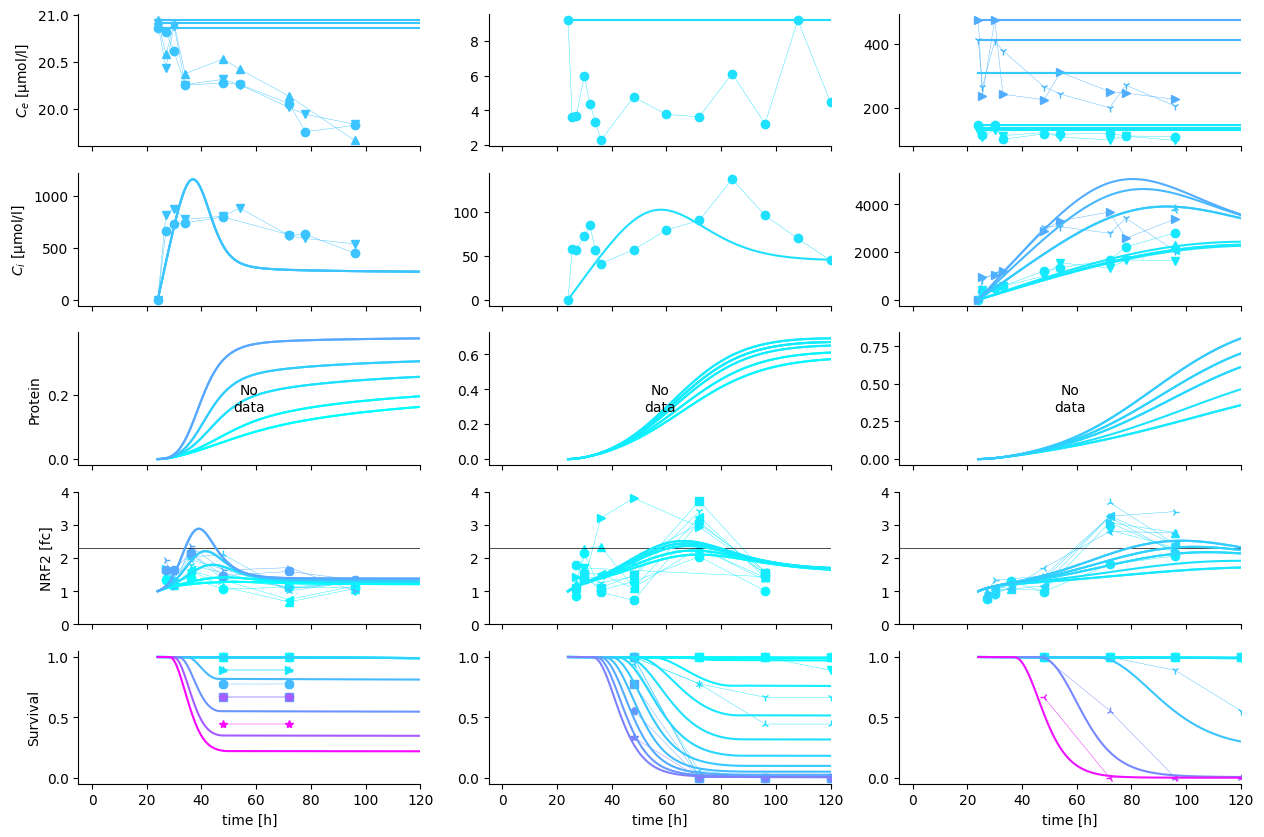

In [10]:
with open(sim.scenario_path + "/experiment_selection_1.json", "r") as fp:
    data_structure = json.load(fp)
    
res = res.assign_coords({"substance": sim.observations.substance})
cmap = mpl.colormaps["cool"]
fig, axes = plt.subplots(len(data_structure), 3, sharex=True, figsize=(15,10))


for r, (v, vdict) in enumerate(data_structure.items()):
    for c, (s, sdict) in enumerate(vdict["substances"].items()):
        sdata = sim.observations.where(sim.observations.substance == s, drop=True)
        C = np.round(sdata.cext_nom.values, 1)
        norm = mpl.colors.Normalize(vmin=C.min(), vmax=C.max())
        for eid in sdict["experiment_ids"]:

            ax, meta, obs_ids, _ = sim._plot.plot_experiment(
                self=sim,
                experiment_id=eid,
                substance=s,
                data_var=v,
                cmap=cmap,
                norm=norm,
                ax=axes[r, c]
            )

            if v != "survival":
                ax.set_xlabel("")

            if v == "P":
                ax.set_ylabel("Protein")
                ax.spines[["right", "top"]].set_visible(False)

            if v == "nrf2":
                ax.set_ylim(0, 4)
                # note that the thresholds are mixed up. Diuron and Diclofenac should swap
                z = sim.inferer.idata.posterior.z.mean(("chain", "draw")).values
                ax.hlines(z, -10, 120, color="black", lw=0.5)

            if c != 0:
                ax.set_ylabel("")

            l = ax.get_legend()
            if l is not None:
                l.remove()
            ax.set_title("")

            res_ids = sim.get_ids(res, {"substance": s, "experiment_id": eid})

            for i in res_ids:
                y = res.sel(id=i)
                ax.plot(res.time, y[v], color=cmap(norm(y.cext.isel(time=0))))


#### Posterior predictions

In order to evaluate the goodness of fit for the posteriors, we are looking
at the posterior predictions.

In order to obtain smoother trajectories, the time resolution is increased,
and posterior predictions are calculated.

Deleted 'lethality' DataVariable(dimensions=['id', 'time'] min=0.0 max=18.0 observed=False dimensions_evaluator=None).
PRETTY PLOT: starting...


Posterior predictions: 100%|██████████| 100/100 [00:04<00:00, 20.05it/s]


PRETTY PLOT: make predictions for Diuron in bin (1/5)
PRETTY PLOT: make predictions for Diuron in bin (2/5)
PRETTY PLOT: make predictions for Diuron in bin (3/5)
PRETTY PLOT: make predictions for Diuron in bin (4/5)
PRETTY PLOT: make predictions for Diuron in bin (5/5)


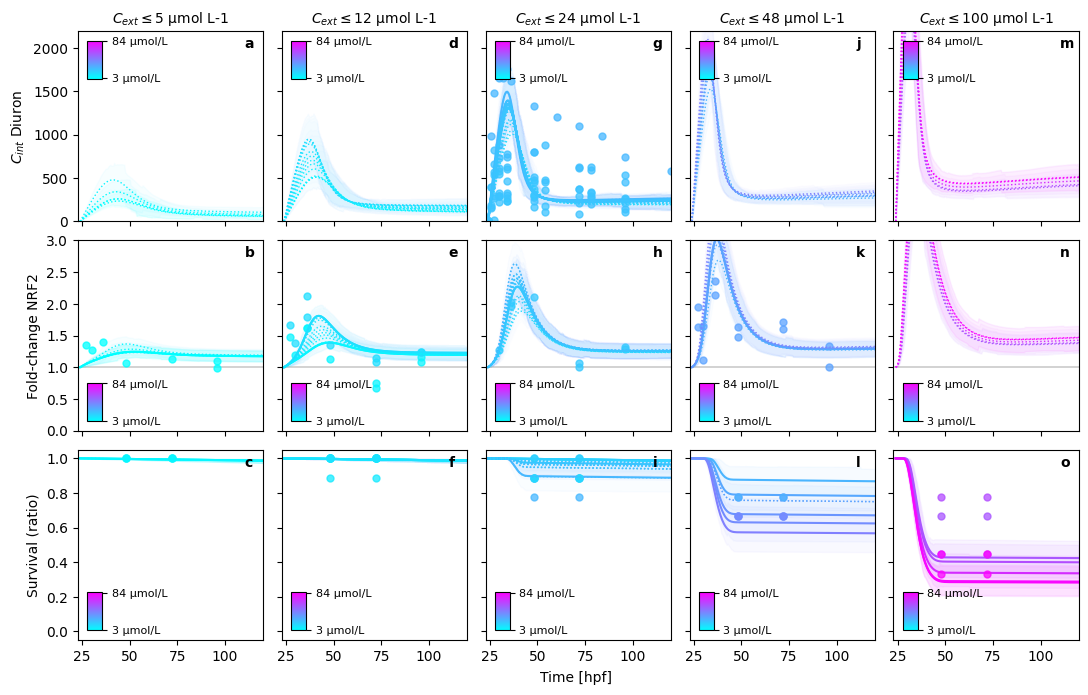

PRETTY PLOT: make predictions for Diclofenac in bin (1/4)
PRETTY PLOT: make predictions for Diclofenac in bin (2/4)
PRETTY PLOT: make predictions for Diclofenac in bin (3/4)
PRETTY PLOT: make predictions for Diclofenac in bin (4/4)


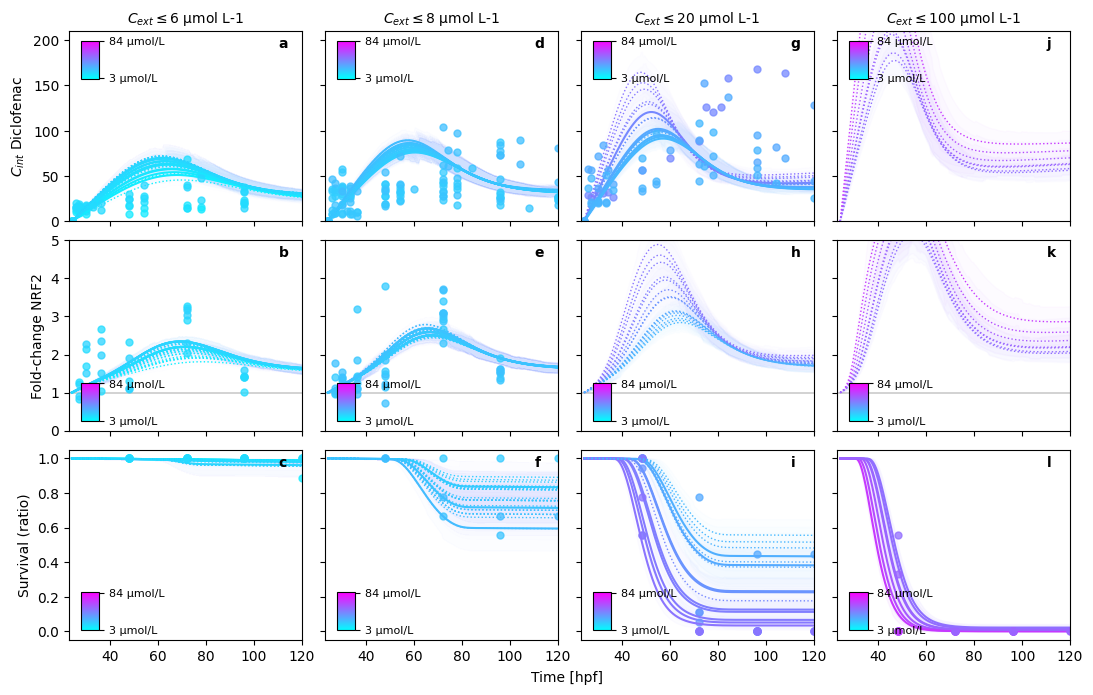

PRETTY PLOT: make predictions for Naproxen in bin (1/6)
PRETTY PLOT: make predictions for Naproxen in bin (2/6)
PRETTY PLOT: make predictions for Naproxen in bin (3/6)
PRETTY PLOT: make predictions for Naproxen in bin (4/6)
PRETTY PLOT: make predictions for Naproxen in bin (5/6)
PRETTY PLOT: make predictions for Naproxen in bin (6/6)


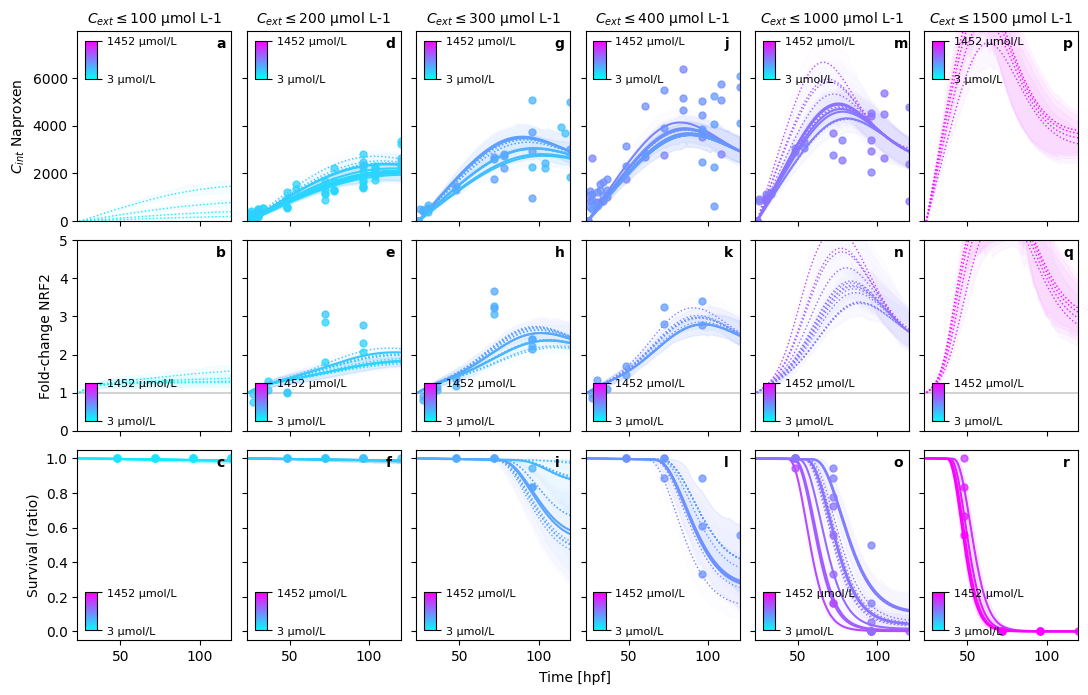

In [12]:
sim.config.inference.n_predictions = 100
sim.coordinates["time"] = np.linspace(24, 120, 200)
sim.seed=1
sim.config.data_structure.remove("lethality")
sim.dispatch_constructor()
_ = sim._plot.pretty_posterior_plot_multisubstance(sim, save=False, show=True)